# Stylized Properties of Asset Returns

In [305]:
import numpy as np
import pandas as pd
pd.set_option('display.precision', 3)
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit, minimize
from decimal import *
from utils import hill_estimator, cross_corr, uncalibrated_GARCH, GARCH

In [306]:
tickers = ['^SPX', 'USDJPY=X', 'NVDA', 'AAPL', 'CL=F', 'XLI']
ticker_relabels = {'^SPX' : 'S&P500', 'USDJPY=X' : 'USD/JPN Spot Rate', 'CL=F' : 'Crude Oil Futures'}
end_date = '2024-08-10'

In [307]:
five_min_prices = yf.download(['^SPX', 'USDJPY=X', 'NVDA', 'AAPL', 'CL=F', 'XLI'], period='max', interval='5m')
five_min_prices = five_min_prices['Adj Close']
five_min_prices = five_min_prices.rename(columns={'^SPX' : 'S&P500', 'USDJPY=X' : 'USD/JPN Spot Rate', 'CL=F' : 'Crude Oil Futures'})
five_min_prices

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,Crude Oil Futures,NVDA,USD/JPN Spot Rate,XLI,S&P500
Datetime,,,,,,
2024-06-27 22:50:00+00:00,NaN,81.90,NaN,160.712,NaN,NaN
2024-06-27 22:55:00+00:00,NaN,81.88,NaN,160.703,NaN,NaN
2024-06-27 23:00:00+00:00,NaN,81.88,NaN,160.752,NaN,NaN
2024-06-27 23:05:00+00:00,NaN,81.88,NaN,160.718,NaN,NaN
2024-06-27 23:10:00+00:00,NaN,81.88,NaN,160.729,NaN,NaN
...,...,...,...,...,...,...
2024-08-26 22:30:00+00:00,NaN,77.18,NaN,144.353,NaN,NaN
2024-08-26 22:35:00+00:00,NaN,77.20,NaN,144.348,NaN,NaN
2024-08-26 22:40:00+00:00,NaN,77.18,NaN,144.394,NaN,NaN


In [308]:
thirty_min_prices = yf.download(['^SPX', 'USDJPY=X', 'NVDA', 'AAPL', 'CL=F', 'XLI'], period='max', interval='30m')
thirty_min_prices = thirty_min_prices['Adj Close']
thirty_min_prices = thirty_min_prices.rename(columns={'^SPX' : 'S&P500', 'USDJPY=X' : 'USD/JPN Spot Rate', 'CL=F' : 'Crude Oil Futures'})
thirty_min_prices

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,Crude Oil Futures,NVDA,USD/JPN Spot Rate,XLI,S&P500
Datetime,,,,,,
2024-06-27 18:30:00,NaN,81.88,NaN,NaN,NaN,NaN
2024-06-27 19:00:00,NaN,81.87,NaN,NaN,NaN,NaN
2024-06-27 19:30:00,NaN,81.88,NaN,NaN,NaN,NaN
2024-06-27 20:00:00,NaN,81.99,NaN,NaN,NaN,NaN
2024-06-27 20:30:00,NaN,81.92,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-08-26 21:30:00,NaN,NaN,NaN,144.517,NaN,NaN
2024-08-26 22:00:00,NaN,NaN,NaN,144.504,NaN,NaN
2024-08-26 22:30:00,NaN,NaN,NaN,144.481,NaN,NaN


In [309]:
five_min_returns = np.log(five_min_prices / five_min_prices.shift(1))
thirty_min_returns = np.log(thirty_min_prices / thirty_min_prices.shift(1))
returns = {'5min' : five_min_returns, '30min' : thirty_min_returns}

In [310]:
SPX_daily_prices = yf.download(['^SPX'], period='max', interval='1d')
SPX_daily_prices = SPX_daily_prices['Adj Close']
SPX_daily_returns = np.log(SPX_daily_prices / SPX_daily_prices.shift(1)).dropna()
SPX_daily_returns

[*********************100%%**********************]  1 of 1 completed


Date
1928-01-03    0.006
1928-01-04   -0.002
1928-01-05   -0.010
1928-01-06    0.006
1928-01-09   -0.009
              ...  
2024-08-20   -0.002
2024-08-21    0.004
2024-08-22   -0.009
2024-08-23    0.011
2024-08-26   -0.003
Name: Adj Close, Length: 24278, dtype: float64

In [311]:
daily_prices = yf.download(['^SPX', 'USDJPY=X', 'NVDA', 'AAPL', 'CL=F', 'XLI'], period='max', end=end_date, interval='1d')
daily_prices = daily_prices['Adj Close']
daily_prices = daily_prices.rename(columns={'^SPX' : 'S&P500', 'USDJPY=X' : 'USD/JPN Spot Rate', 'CL=F' : 'Crude Oil Futures'})
daily_prices = daily_prices.dropna()
daily_prices.head()

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,Crude Oil Futures,NVDA,USD/JPN Spot Rate,XLI,S&P500
Date,,,,,,
2000-08-23,0.819,32.05,0.286,106.98,19.954,1505.97
2000-08-24,0.846,31.63,0.294,106.99,20.166,1508.31
2000-08-25,0.857,32.05,0.287,106.80,20.257,1506.45
2000-08-28,0.876,32.87,0.298,106.59,20.529,1514.09
2000-08-29,0.893,32.72,0.297,106.13,20.398,1509.84


We need to correct for the remarkable fact that on March 20 2020, when the global economy fully in the midst of the COVID-19 pandemic, WTI front-month crude oil futures were negative! There was such an oversupply of oil, with subsequent storage costs so high, that owners of CL future contracts were offering to pay people to take supply off their hands.

In [312]:
print(np.round(daily_prices['Crude Oil Futures'][pd.to_datetime('2020-04-20')],2))
daily_prices.drop(pd.to_datetime('2020-04-20'), inplace=True)

-37.63


In [313]:
def log_return(group):
    if group.size <= 5:
        return None
    if group.name.year==2001:
        print(group.iloc[-1], group.iloc[0])
    return np.log(group.iloc[-1] / group.iloc[0])

In [314]:
def last_day(group):
    if group.size == 0:
        return None
    else:
        return group.iloc[-1]

In [315]:
daily_returns = np.log(daily_prices / daily_prices.shift(1)).dropna()
frequencies = ['5B', 'MS', 'QS', 'YS']
periods = ['weekly', 'monthly', 'quarterly', 'annually']
returns['daily'] = daily_returns
for period, freq in zip(periods, frequencies):
    last_day_of_period = daily_prices.groupby(pd.Grouper(freq=freq)).apply(last_day).dropna()
    freq_returns = np.log(last_day_of_period / last_day_of_period.shift(1)).dropna()
    returns[period] = freq_returns

In [316]:
start_dates = [returns[label].index[0].date() for label in returns.keys()]
end_dates = [returns[label].index[-1].date() for label in returns.keys()]
date_df = pd.DataFrame([start_dates, end_dates], columns=returns.keys(), index=['start', 'end'])
date_df

,5min,30min,daily,weekly,monthly,quarterly,annually
start,2024-06-27,2024-06-27,2000-08-24,2000-08-30,2000-09-01,2000-10-01,2001-01-01
end,2024-08-26,2024-08-26,2024-08-09,2024-08-07,2024-08-01,2024-07-01,2024-01-01


In [317]:
hourly_prices =  yf.download(tickers=tickers, period='max', interval='1h')
hourly_prices = hourly_prices['Adj Close']
hourly_prices = hourly_prices.rename(columns=ticker_relabels)
hourly_prices.head()

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,Crude Oil Futures,NVDA,USD/JPN Spot Rate,XLI,S&P500
Datetime,,,,,,
2022-08-28 22:00:00+00:00,NaN,92.82,NaN,NaN,NaN,NaN
2022-08-28 23:00:00+00:00,NaN,92.95,NaN,138.159,NaN,NaN
2022-08-29 00:00:00+00:00,NaN,93.43,NaN,138.382,NaN,NaN
2022-08-29 01:00:00+00:00,NaN,93.93,NaN,138.510,NaN,NaN
2022-08-29 02:00:00+00:00,NaN,94.23,NaN,138.458,NaN,NaN


## Properties 1 (Heavy tails) and 2 (Aggregational normality):

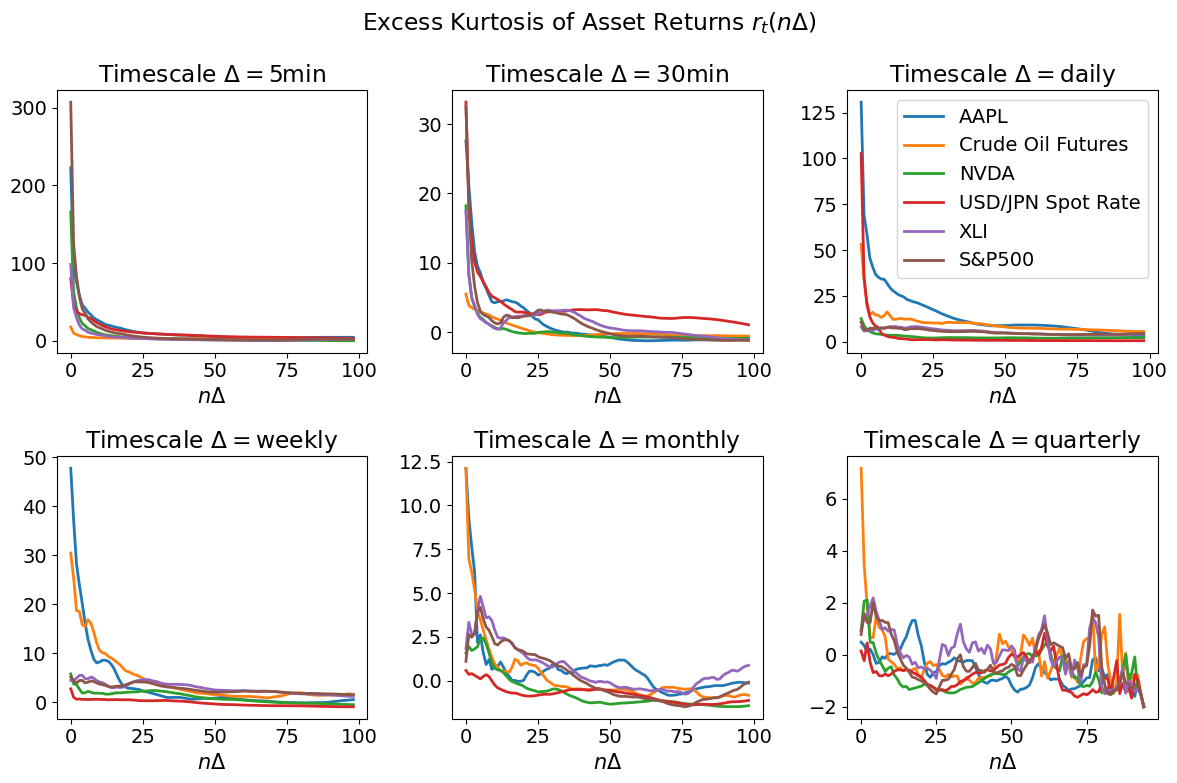

In [363]:
#Kurtosis as a function of Timescale:
fig, axs = plt.subplots(2,3, figsize=(12,8), tight_layout='True')
fig.suptitle(r'Excess Kurtosis of Asset Returns $r_t(n\Delta)$')

weekly_prices = daily_prices.groupby(pd.Grouper(freq='5B')).apply(last_day)
monthly_prices = daily_prices.groupby(pd.Grouper(freq='MS')).apply(last_day)
quarterly_prices = daily_prices.groupby(pd.Grouper(freq='QS')).apply(last_day)
prices = {'5min': five_min_prices, '30min' : thirty_min_prices, 'daily' : daily_prices, 'weekly' : weekly_prices, 'monthly' : monthly_prices, 'quarterly' : quarterly_prices}

for j, ax in enumerate(axs.flatten()):
    period = list(prices.keys())[j]
    period_prices = prices[period]
    xlim = []
    for label in period_prices.columns:
        asset_returns = period_prices[label].dropna()
        kurtosis = []
        for i in range(1,min(100,asset_returns.size)):
            r = np.log(asset_returns / asset_returns.shift(i)).dropna()
            kurtosis.append(stats.kurtosis(r))
        kurtosis = np.array(kurtosis)
        ax.plot(kurtosis, label=label, linewidth=2)
        #xlim.append(np.argmax(kurtosis<=0)) 
    ax.set_title(rf'Timescale $\Delta=${period}')
    ax.set_xlabel(r'$n\Delta$')
    if j == 2:
        ax.legend()

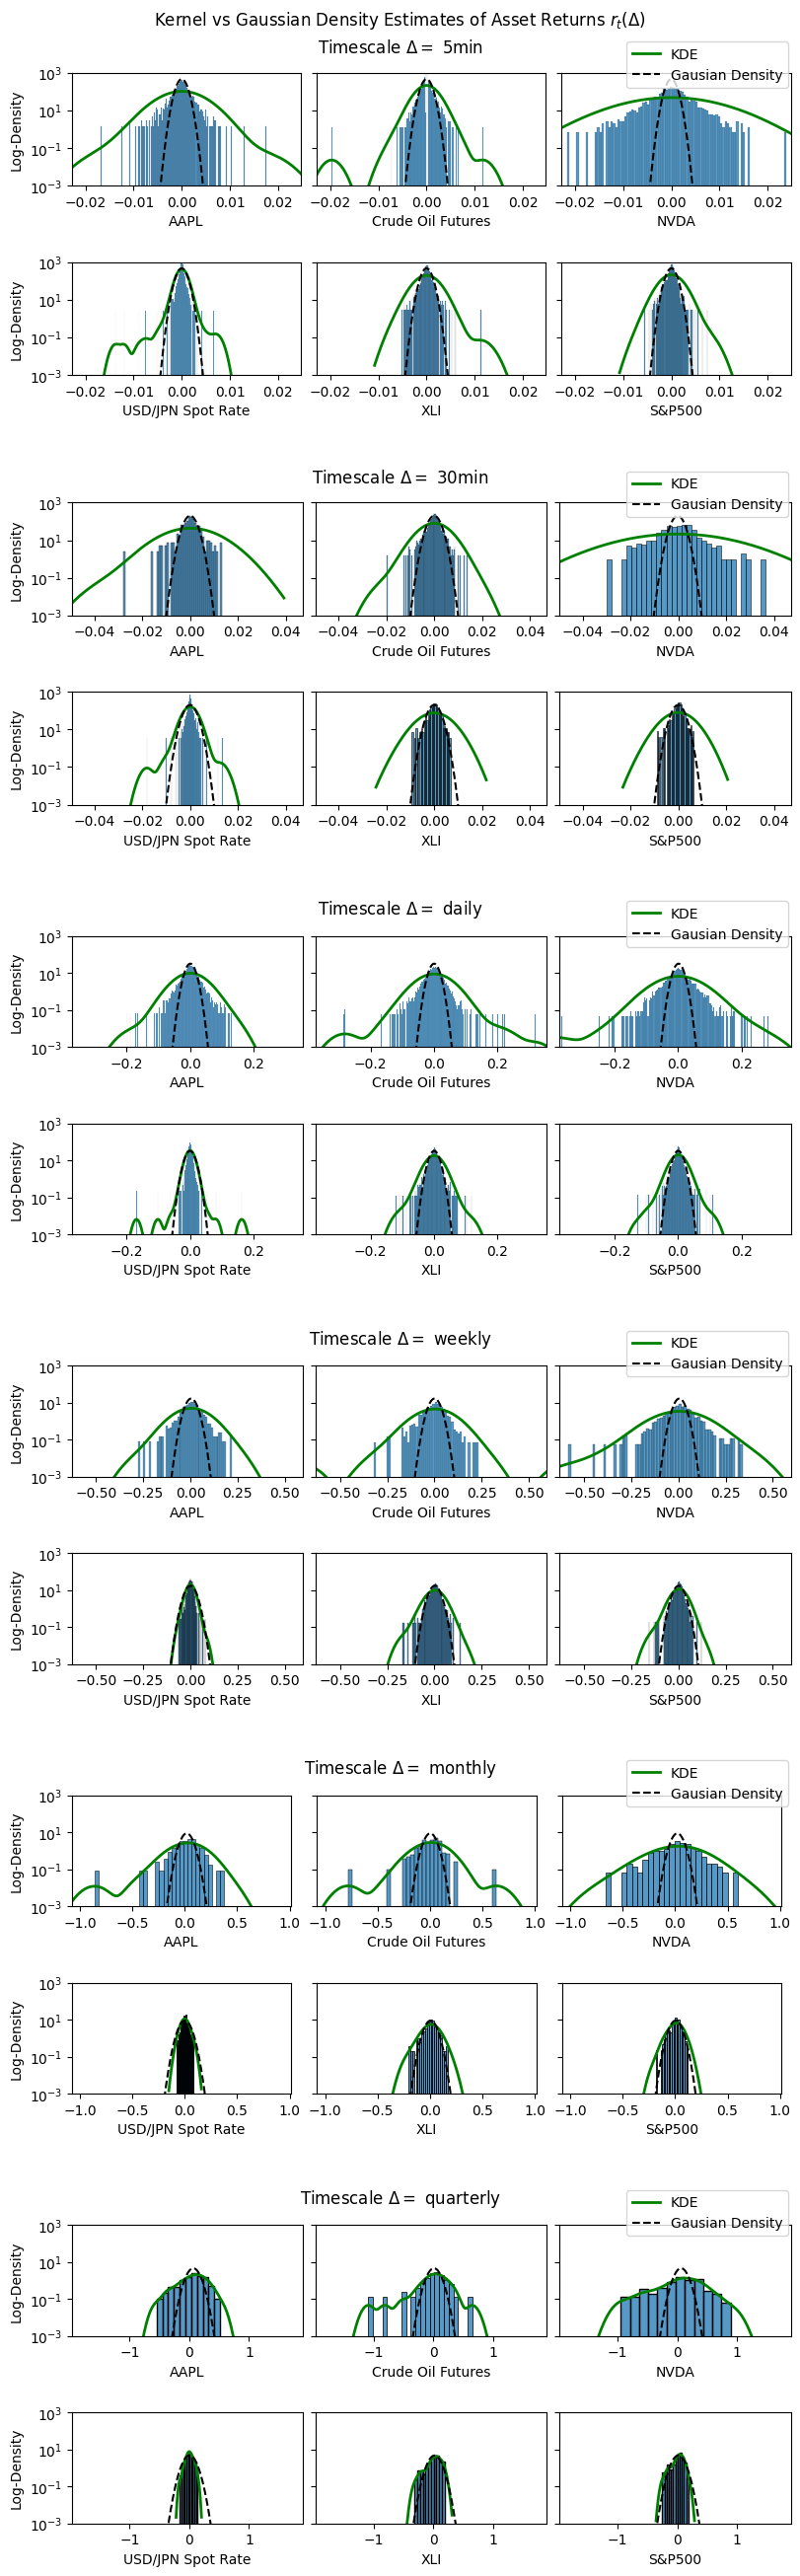

In [319]:
fig = plt.figure(layout='constrained', figsize=(8,26))
fig.suptitle(r'Kernel vs Gaussian Density Estimates of Asset Returns $r_t(\Delta)$')
subfigs = fig.subfigures(6,1, hspace=0.1)

kernel_smoothing_param = [10,8,8,5,3,1]

for i, subfig in enumerate(subfigs):
    axs = subfig.subplots(2,3, sharey = True)
    period = list(returns.keys())[i]
    subfig.suptitle(rf'Timescale $\Delta=$ {period}')
    period_returns = returns[period]
    period_means = period_returns.mean()
    period_stds = period_returns.std()
    period_mins = period_returns.min()
    period_maxs = period_returns.max()
    bw_adjust = kernel_smoothing_param[i]
    for j, ax in enumerate(axs.flatten()):
        asset_label = period_returns.columns[j]
        asset_returns = period_returns[asset_label]
        sns.histplot(ax=ax, data=asset_returns, stat='density', edgecolor = 'k')
        sns.kdeplot(ax=ax, data=asset_returns, bw_adjust=bw_adjust, label = 'KDE', color='g', linewidth=2, legend=False)
        ax.set_yscale('log')
        ax.set_ylim(10**(-3), 10**3)
        ax.set_xlabel(asset_label)
        ax.set_ylabel('Log-Density')
        x1_lim, x2_lim =  period_mins[label]-20*period_stds[label], period_maxs[label]+20*period_stds[label]
        ax.set_xlim(x1_lim, x2_lim)
        x = np.linspace(x1_lim,x2_lim,300) 
        normal = stats.norm.pdf(x, period_means[asset_label], period_stds[label])
        sns.lineplot(ax=ax, x=x, y=normal, color='black', linestyle='dashed', label='Gausian Density', legend=False)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='upper right');

### Hill estimation of tail indices:

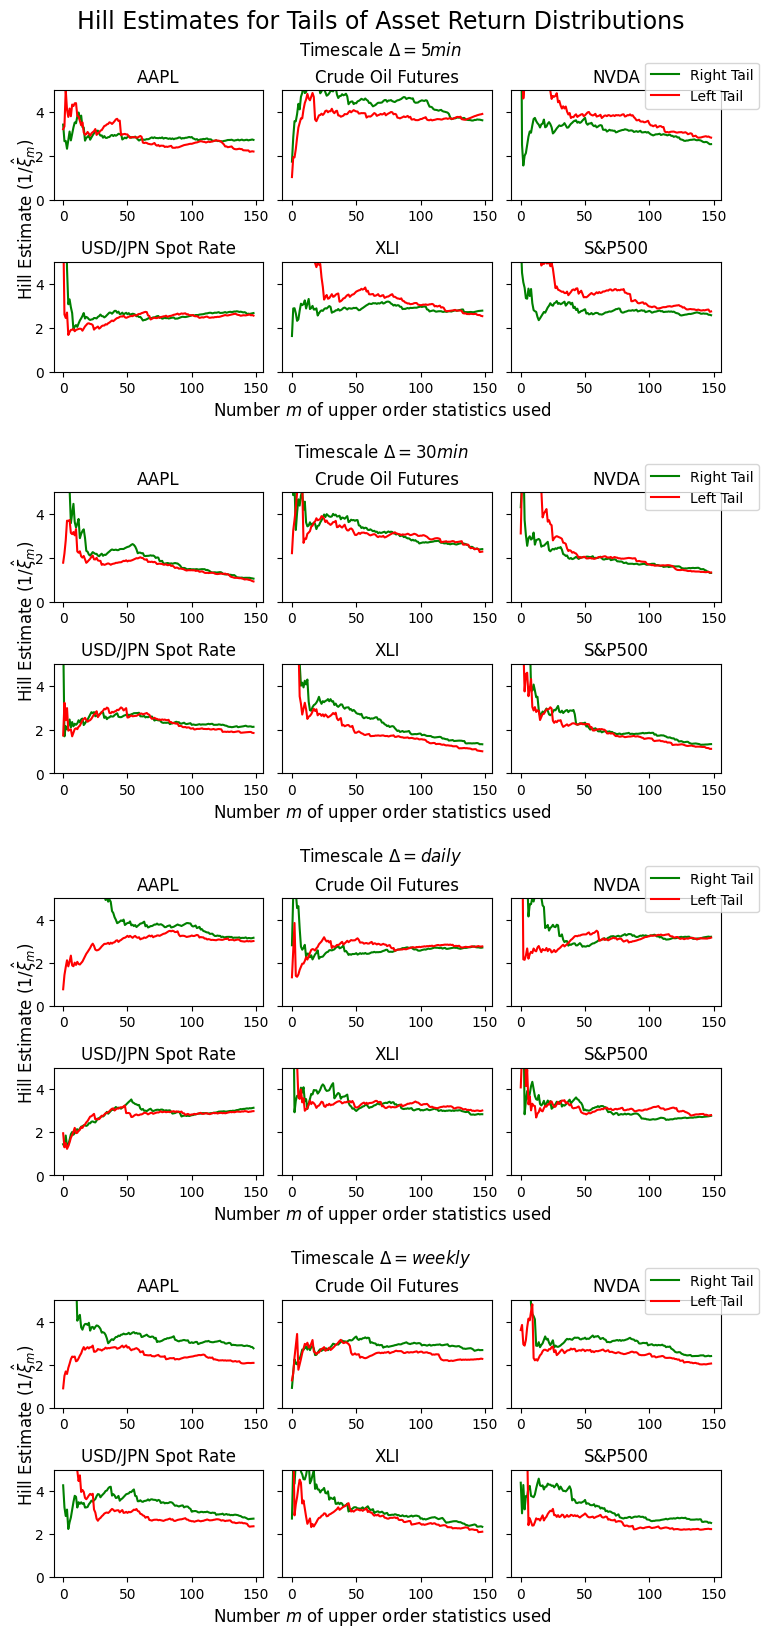

In [320]:
fig = plt.figure(layout='constrained', figsize=(7,16))
fig.suptitle('Hill Estimates for Tails of Asset Return Distributions', fontsize=17)
subfigs = fig.subfigures(4, hspace=0.1)

for i, subfig in enumerate(subfigs):
    axs = subfig.subplots(2,3, sharey=True)
    period = list(returns.keys())[i]
    subfig.suptitle(fr'Timescale $\Delta={period}$')
    period_returns = returns[period] 
    positive_returns = period_returns[period_returns>0]
    negative_returns = -period_returns[period_returns<0] 
    for j, ax in enumerate(axs.flatten()):
        label = period_returns.columns[j]
        pos_return = positive_returns[label].dropna()
        neg_return = negative_returns[label].dropna()
        m_pos = min(pos_return.size-1,150)
        m_neg = min(neg_return.size-1,150)
        right_estimate = []
        left_estimate = []
        for k in range(1,m_pos):
            right_estimate.append(hill_estimator(pos_return, k))
        for k in range(1,m_neg):
            left_estimate.append(hill_estimator(neg_return, k))
        ax.plot(right_estimate, color='green', label='Right Tail')
        ax.plot(left_estimate, color='red', label='Left Tail')
        ax.set_ylim(0,5)
        ax.set_title(label)
    subfig.text(-0.03, 0.5, r'Hill Estimate $(1/\hat{\xi}_m)$', va='center', rotation='vertical', fontdict={'size' : 12});
    subfig.text(0.26, -0.03, r'Number $m$ of upper order statistics used', va='center', fontdict={'size' : 12});
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.05,0.95));


### Consequences of incorrectly assuming thin tails

In [321]:
SPX_DR_left_tail =  -SPX_daily_returns[SPX_daily_returns<0]

In [322]:
c,l,s = stats.invweibull.fit(SPX_DR_left_tail, f0=3)

In [323]:
frechet_fit = stats.invweibull.freeze(c=c, loc=l, scale=s)
normal_fit = stats.halfnorm.freeze(loc=0, scale=SPX_daily_returns.std())

In [324]:
frechet_pdf = frechet_fit.pdf(x=np.linspace(0,0.15,300))
normal_pdf = normal_fit.pdf(x=np.linspace(0,0.15,300))

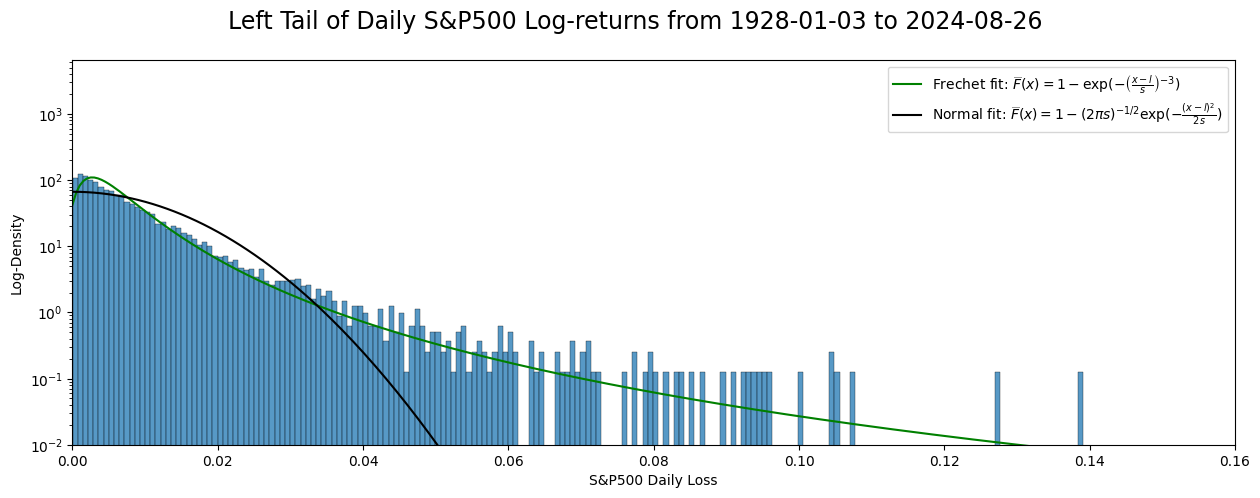

In [325]:
plt.figure(figsize=(15,5))
plt.suptitle(f'Left Tail of Daily S&P500 Log-returns from {SPX_daily_returns.index[0].date()} to {SPX_daily_returns.index[-1].date()}', fontsize=17)
sns.histplot(SPX_DR_left_tail, stat='density')
x=np.linspace(0,0.15,300)
plt.plot(x,frechet_pdf, color='green', label=r'Frechet fit: $\widebar{F}(x)=1-\exp(-\left(\frac{x-l}{s}\right)^{-3})$')
plt.plot(x,normal_pdf, color='black', label=r'Normal fit: $\widebar{F}(x)=1-(2\pi s)^{-1/2}\exp(-\frac{(x-l)^2}{2s})$')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('S&P500 Daily Loss')
plt.gca().set_ylabel('Log-Density')
plt.gca().set_ylim(10**(-2))
plt.gca().set_xlim(0,0.16)
plt.legend();

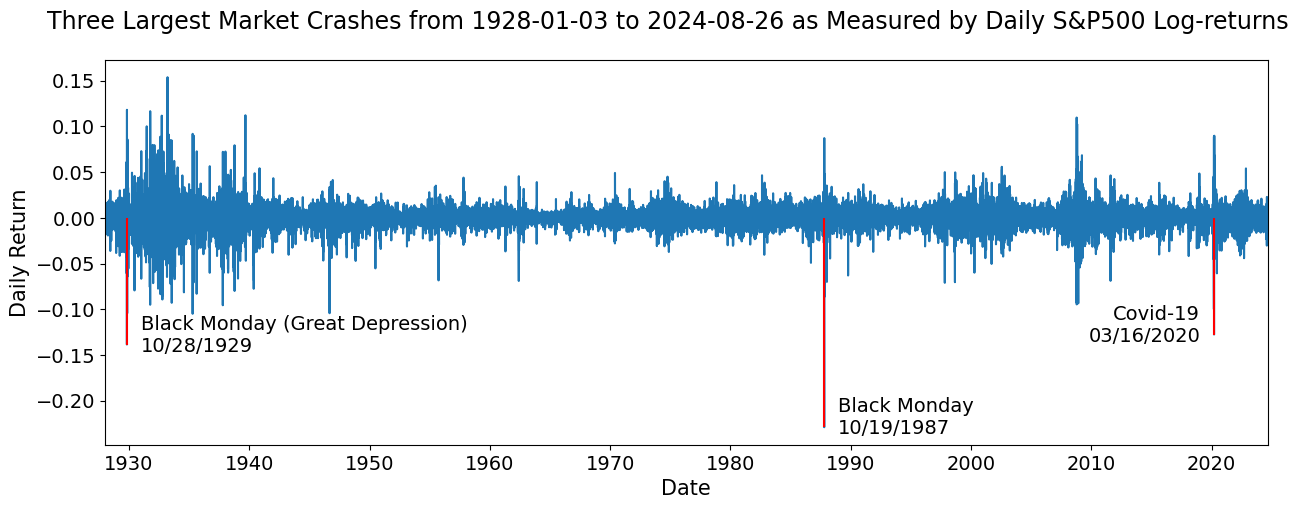

In [326]:
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size':14, 'axes.labelsize':15, 'xtick.labelsize':14, 'ytick.labelsize':14})
plt.suptitle(f'Three Largest Market Crashes from {SPX_daily_returns.index[0].date()} to {SPX_daily_returns.index[-1].date()} as Measured by Daily S&P500 Log-returns', fontsize=17)
dates = SPX_daily_returns.index
worst_dates = SPX_daily_returns.sort_values()[:3].sort_index()
labels = ['Black Monday (Great Depression)\n10/28/1929', 'Black Monday \n10/19/1987', 'Covid-19\n03/16/2020']
alignments = [['left', 10], ['left', 10], ['right', -10]]
plt.plot(SPX_daily_returns)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().set_xlim(dates[0],dates[-1])
plt.gca().set_xlabel('Date')
plt.gca().set_ylabel('Daily Return')
for i, date in enumerate(worst_dates.index):
    plt.vlines(x=date, ymin=0, ymax=worst_dates[date], color='red')
    plt.annotate(text=labels[i], xy=(date,worst_dates[date]), xytext = (alignments[i][1],-5), textcoords = 'offset points', ha=alignments[i][0])

In [327]:
N = SPX_DR_left_tail.size
frechet_sample = frechet_fit.rvs(size=N)
normal_sample = normal_fit.rvs(size=N)

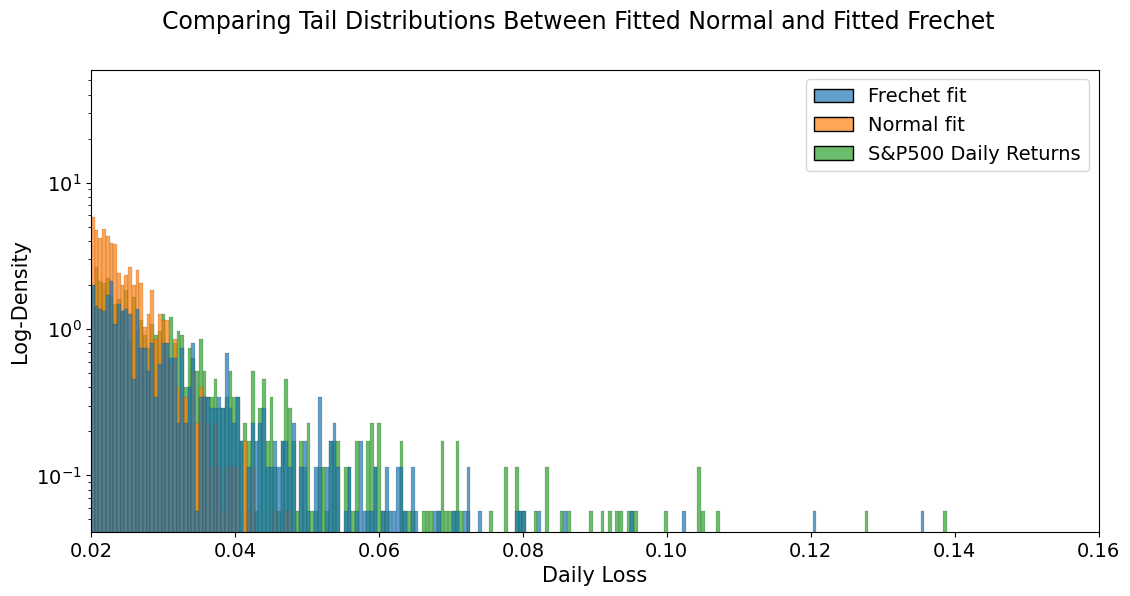

In [328]:
left_tails = pd.DataFrame({'Frechet fit' : frechet_sample, 'Normal fit' : normal_sample, 'S&P500 Daily Returns' : SPX_DR_left_tail})
plt.figure(figsize=(13,6))
plt.suptitle('Comparing Tail Distributions Between Fitted Normal and Fitted Frechet', fontsize=17)
sns.histplot(left_tails, alpha=0.7, stat='density')
plt.gca().set_yscale('log')
plt.gca().set_xlim(0.02,0.16);
plt.gca().set_ylabel('Log-Density');
plt.gca().set_xlabel('Daily Loss');

## Property 3 (Gain/Loss Asymmetry)

In [329]:
skew = {}
skew = {}
for period in returns.keys():
    skew[period] = returns[period].skew()
    skew = pd.DataFrame(skew)
    skew.index.name = 'Ticker'

skew

,5min,30min,daily,weekly,monthly,quarterly,annually
Ticker,,,,,,,
AAPL,-0.347,-1.078,-4.473,-3.165,-1.902,-0.628,-0.517
Crude Oil Futures,-0.642,-0.507,-1.817,-0.457,-0.934,-1.758,-0.639
NVDA,0.385,0.143,-0.444,-0.611,-0.367,-0.742,-1.146
USD/JPN Spot Rate,-2.254,-1.124,-0.527,-0.089,0.290,-0.068,-0.026
XLI,0.363,-0.682,-0.372,-0.674,-0.676,-1.005,-1.390
S&P500,0.052,-0.597,-0.399,-0.860,-0.698,-0.988,-1.445


## Property 4 (Absence of autocorrelation)

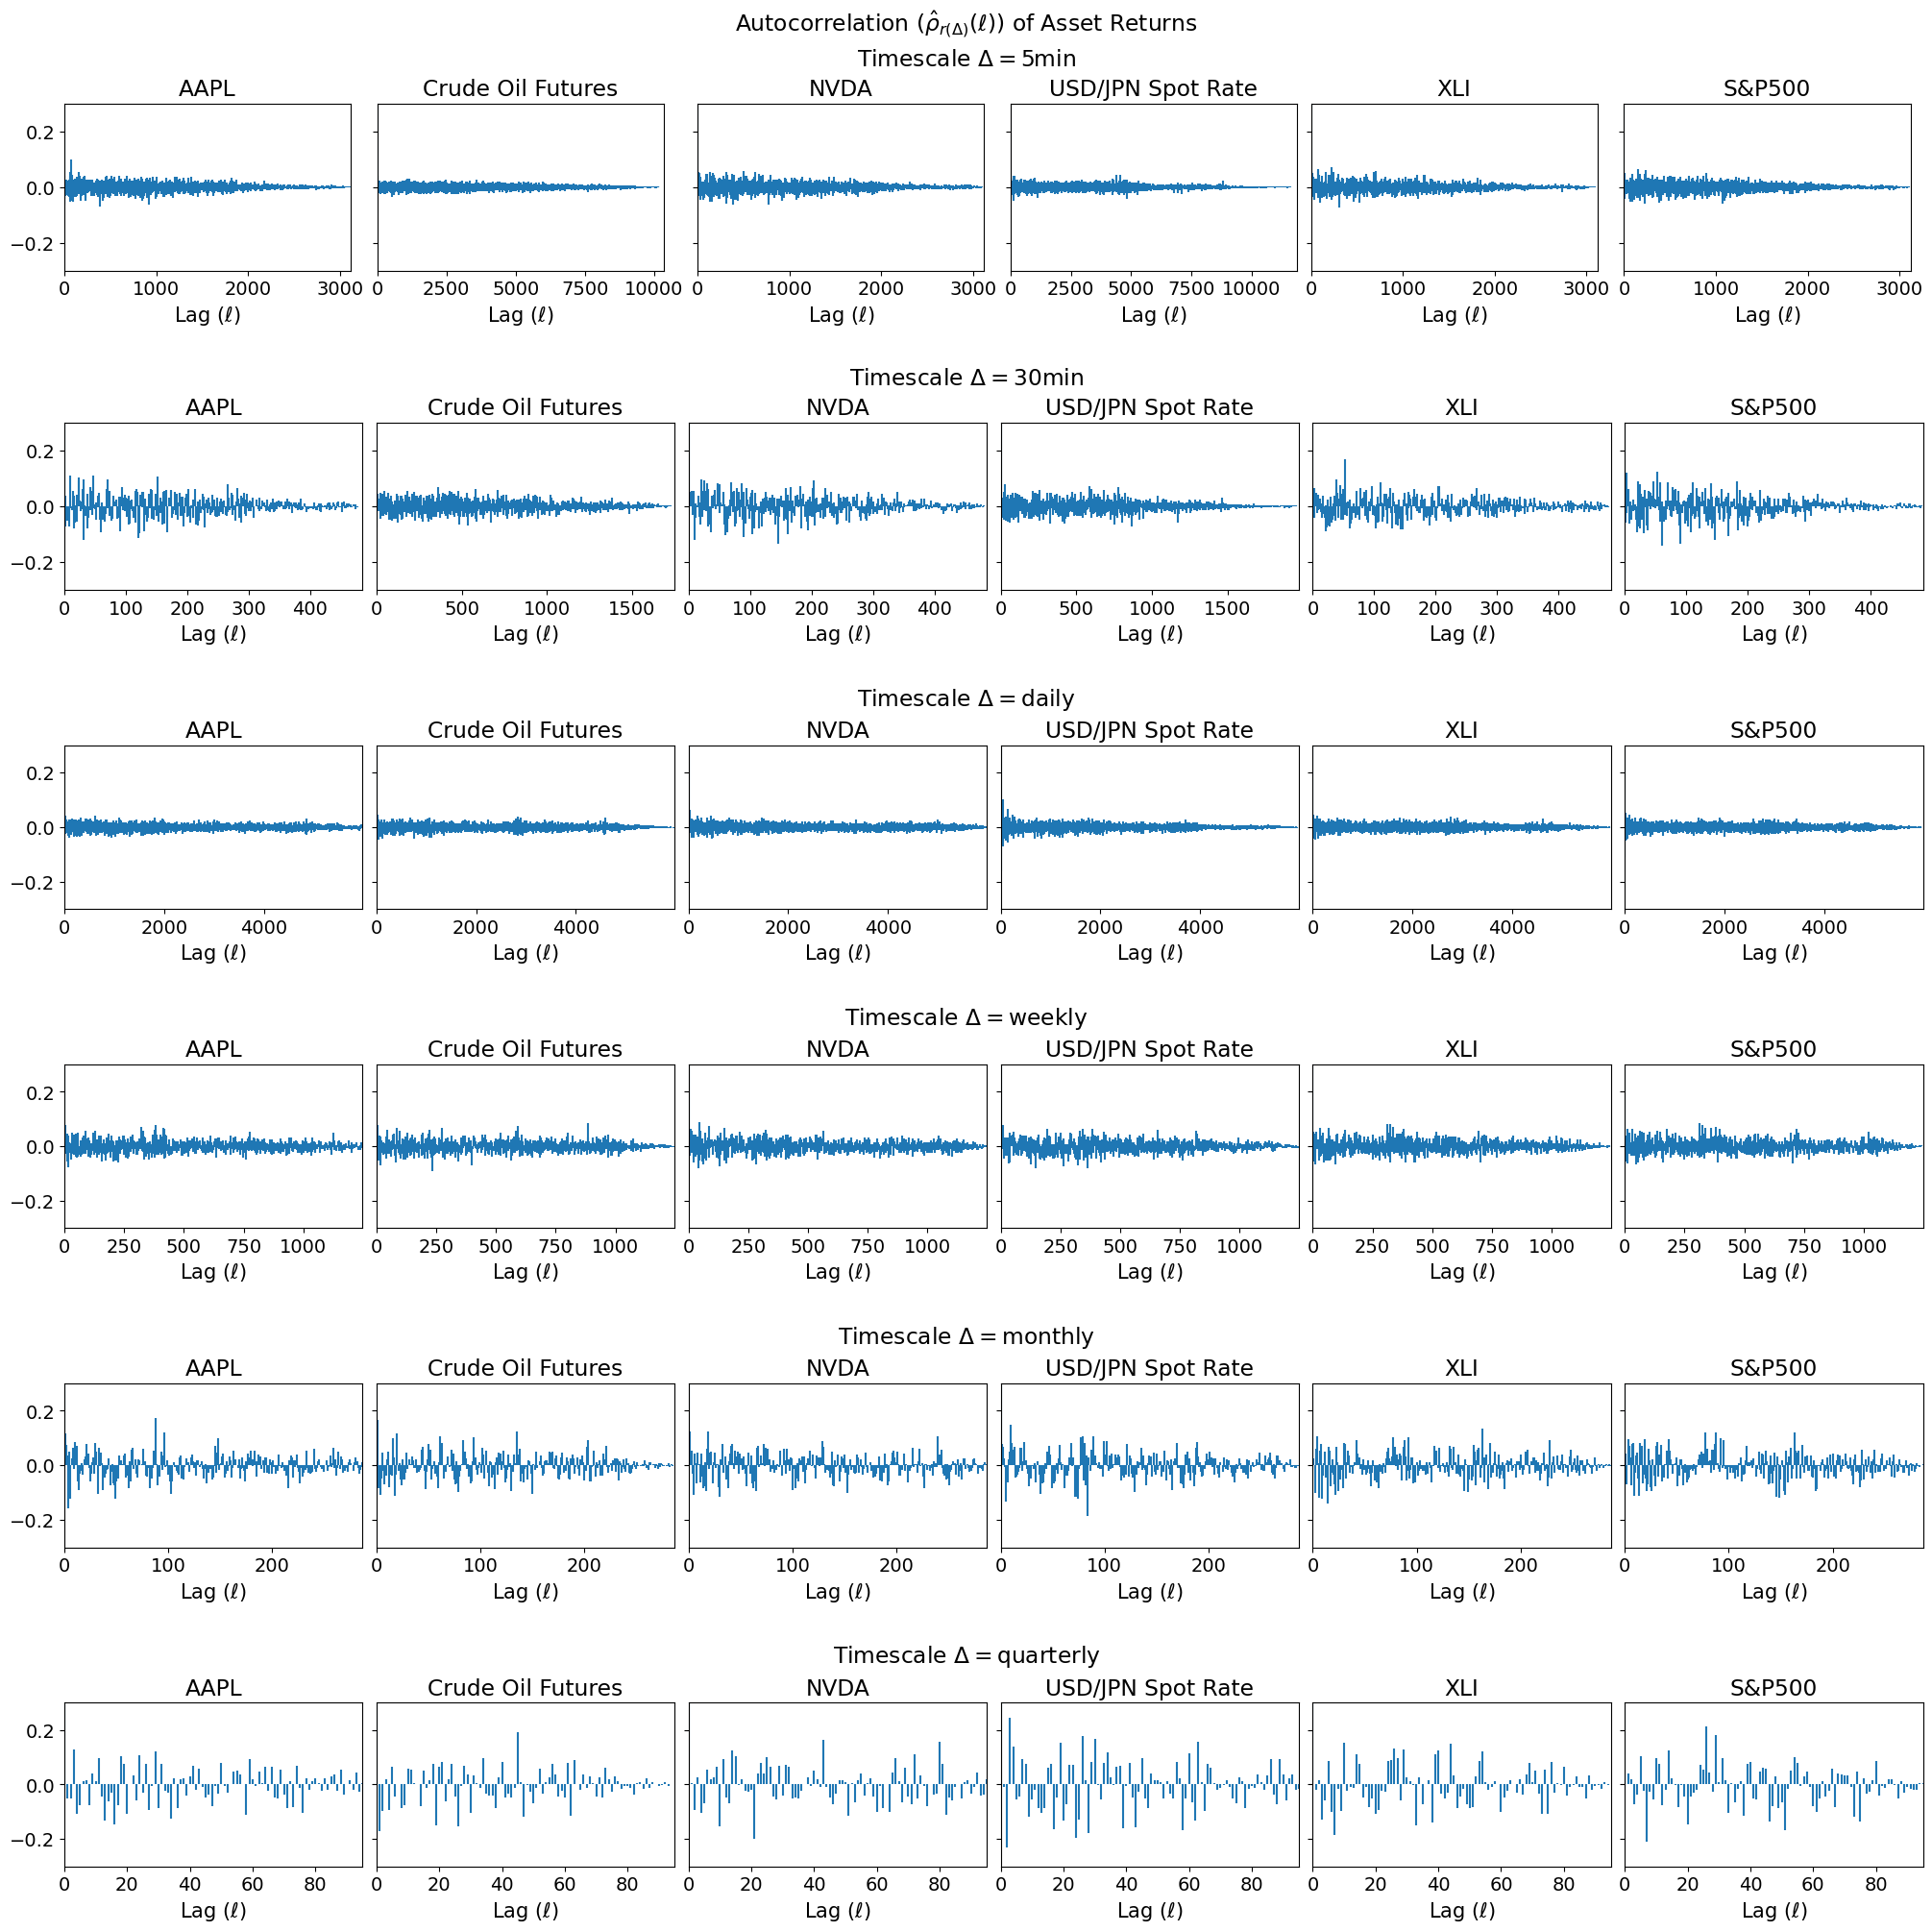

In [351]:
fig = plt.figure(figsize=(20,20), layout='constrained')
subfigs = fig.subfigures(6,1, hspace=0.1)

for i, subfig in enumerate(subfigs):
    axs = subfig.subplots(1,6, sharey=True)
    period = list(returns.keys())[i]
    period_returns = returns[period]
    labels = period_returns.columns 
    subfig.suptitle(rf'Timescale $\Delta=${period}')
    for j, ax in enumerate(axs.flatten()):
        label = labels[j]
        asset_returns = period_returns[label].dropna()
        maxlags = asset_returns.size-1
        x=np.linspace(0,maxlags,maxlags+1)
        y=cross_corr(asset_returns,asset_returns)
        ax.vlines(x=x,ymin=0, ymax=y)
        #ax.plot(x,y)
        #ax.acorr(asset_returns, maxlags = asset_returns.size-1)
        ax.set_ylim(-0.3,0.3)
        ax.set_xlim(0, maxlags)
        ax.set_xlabel(r'Lag $(\ell)$')
        ax.set_title(label)

fig.suptitle(r'Autocorrelation $(\hat{\rho}_{r(\Delta)}(\ell))$ of Asset Returns');

## Property 5 (Volatility clustering)

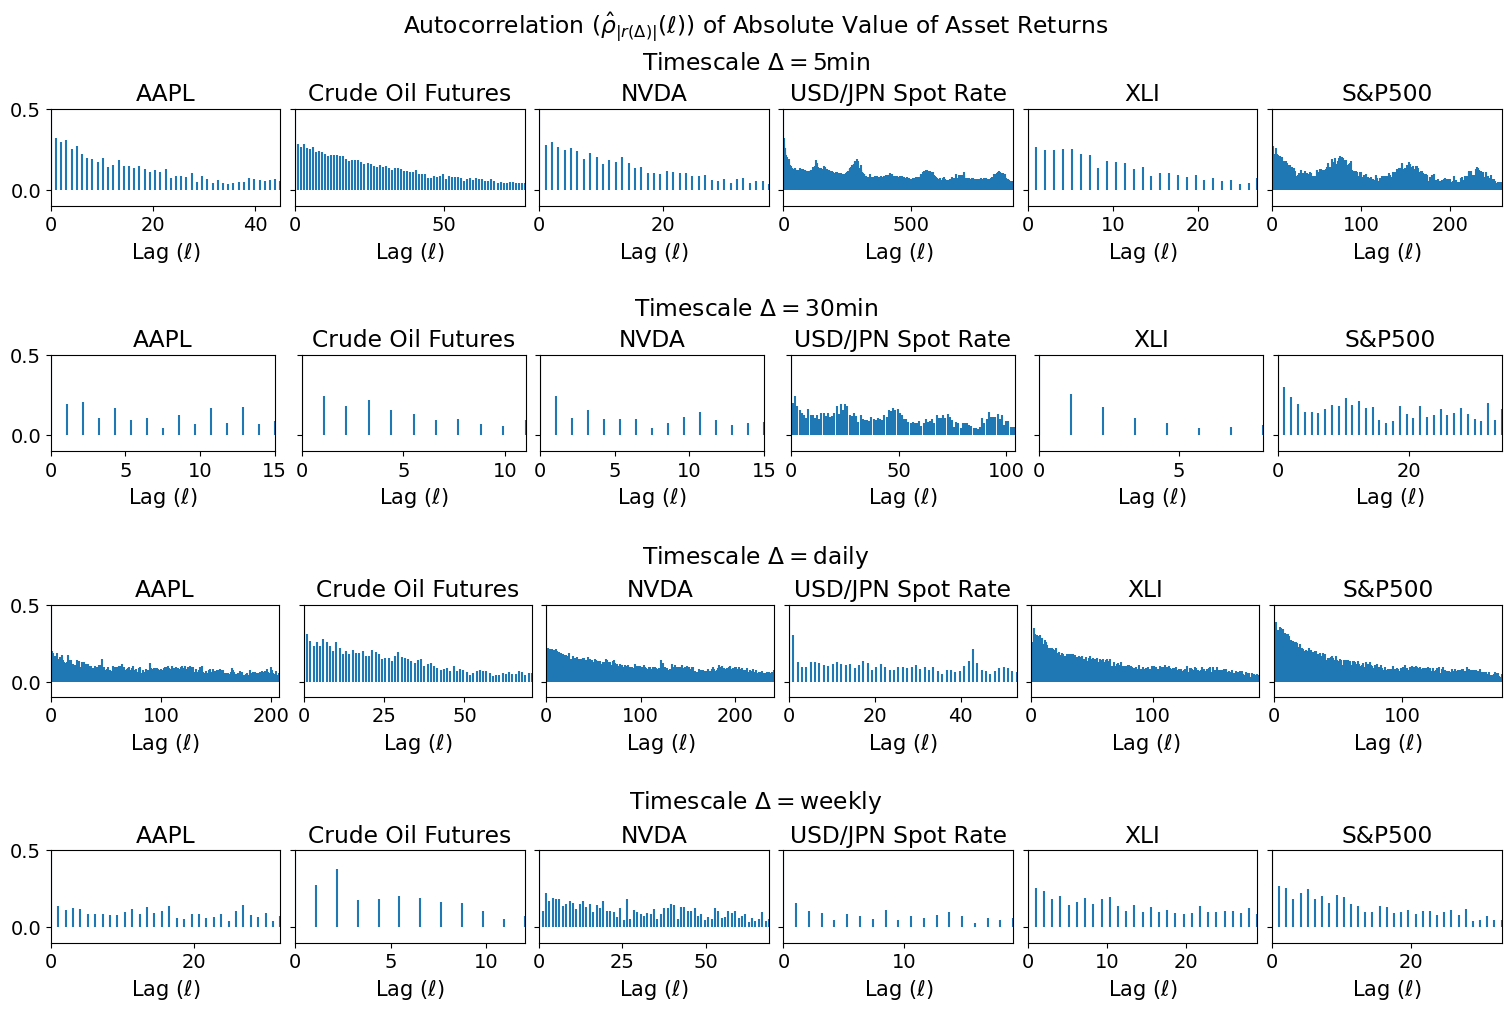

In [352]:
fig = plt.figure(figsize=(15,10), constrained_layout=True)
subfigs = fig.subfigures(4,1, hspace=0.1)

for i, subfig in enumerate(subfigs):
    axs = subfig.subplots(1,6, sharey=True)
    period = list(returns.keys())[i]
    period_returns = returns[period]
    labels = period_returns.columns 
    subfig.suptitle(rf'Timescale $\Delta=${period}')
    for j, ax in enumerate(axs.flatten()):
        label = labels[j]
        asset_returns = period_returns[label].dropna()
        y=cross_corr(np.abs(asset_returns),np.abs(asset_returns))
        maxlags = np.argmax(y<0.03)
        y=y[:maxlags]
        x=np.linspace(0,maxlags,maxlags)
        ax.vlines(x=x,ymin=0, ymax=y)
        #ax.plot(x,y)
        #ax.acorr(asset_returns, maxlags = asset_returns.size-1)
        ax.set_ylim(-0.1,0.5)
        ax.set_xlim(0, maxlags)
        ax.set_xlabel(r'Lag $(\ell)$')
        ax.set_title(label)

fig.suptitle(r'Autocorrelation $(\hat{\rho}_{|r(\Delta)|}(\ell))$ of Absolute Value of Asset Returns');

## Property 6 (Long-range Dependence)

In [332]:
def powerlaw(x,C,a,b):
    return C*x**a + b

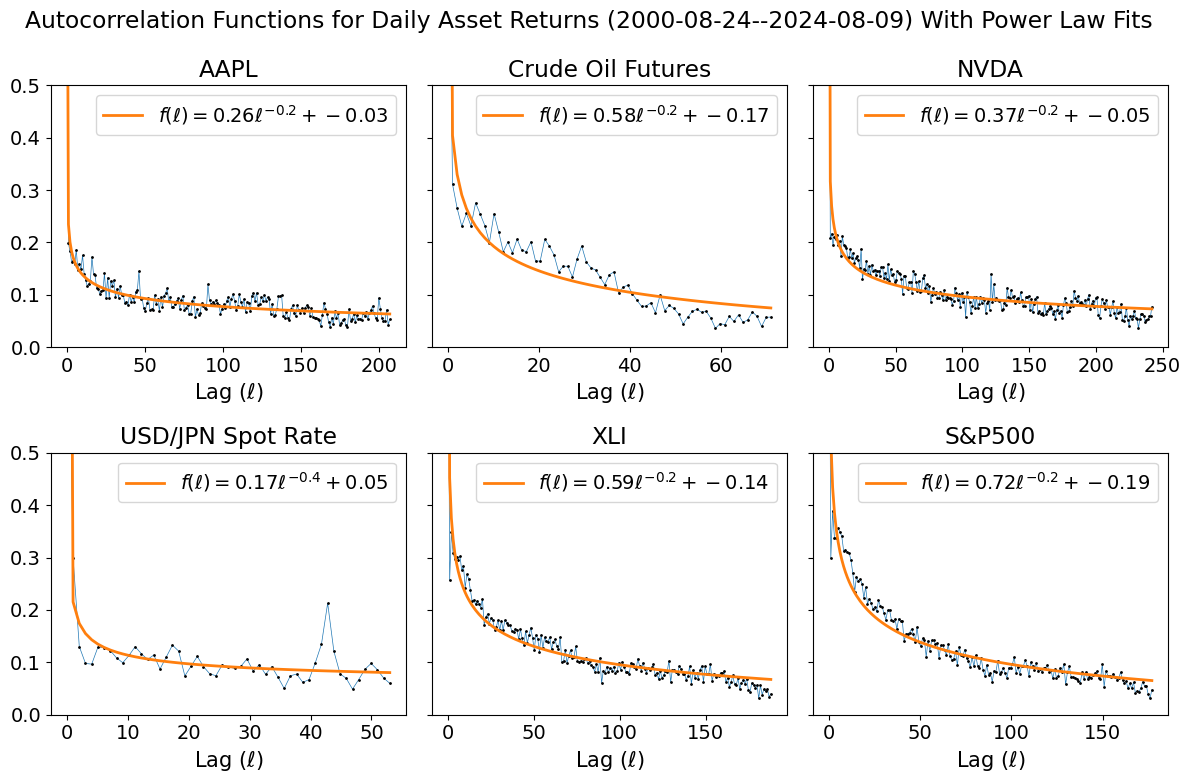

In [361]:
fig, axs = plt.subplots(2,3, figsize=(12,8), sharey=True, tight_layout=True)
date_0, date_1 = date_df['daily']['start'], date_df['daily']['end']
plt.subplots_adjust(hspace=0.1)
fig.suptitle(f'Autocorrelation Functions for Daily Asset Returns ({date_0}--{date_1}) With Power Law Fits')

for i, ax in enumerate(axs.flatten()):
    asset_returns = returns['daily'].iloc[:,i].dropna()
    y=cross_corr(np.abs(asset_returns),np.abs(asset_returns))
    xlim = np.argmax(y<0.03)
    y=y[:xlim]
    x=np.linspace(0.001,xlim,xlim)
    ax.plot(x,y, marker='.', ms=2, mfc='black', mec='black', linewidth=0.5)
    ax.set_ylim(0,0.5)
    ax.set_xlabel(r'Lag $(\ell)$')
    ax.set_title(returns['daily'].columns[i])
    params = curve_fit(xdata=x[1:],ydata=y[1:],f=powerlaw, bounds=((0,-0.4,-np.inf),(np.inf,-0.2,np.inf)), p0=(0.8,-0.3,0.04))[0]
    ax.plot(x, params[0]*x**params[1] + params[2], linewidth=2, label=fr'$f(\ell)={round(params[0],2)}\ell^{{{round(params[1],2)}}}+{round(params[2],2)}$')
    ax.legend()

### Sample autocorrelation detecting non-stationarity

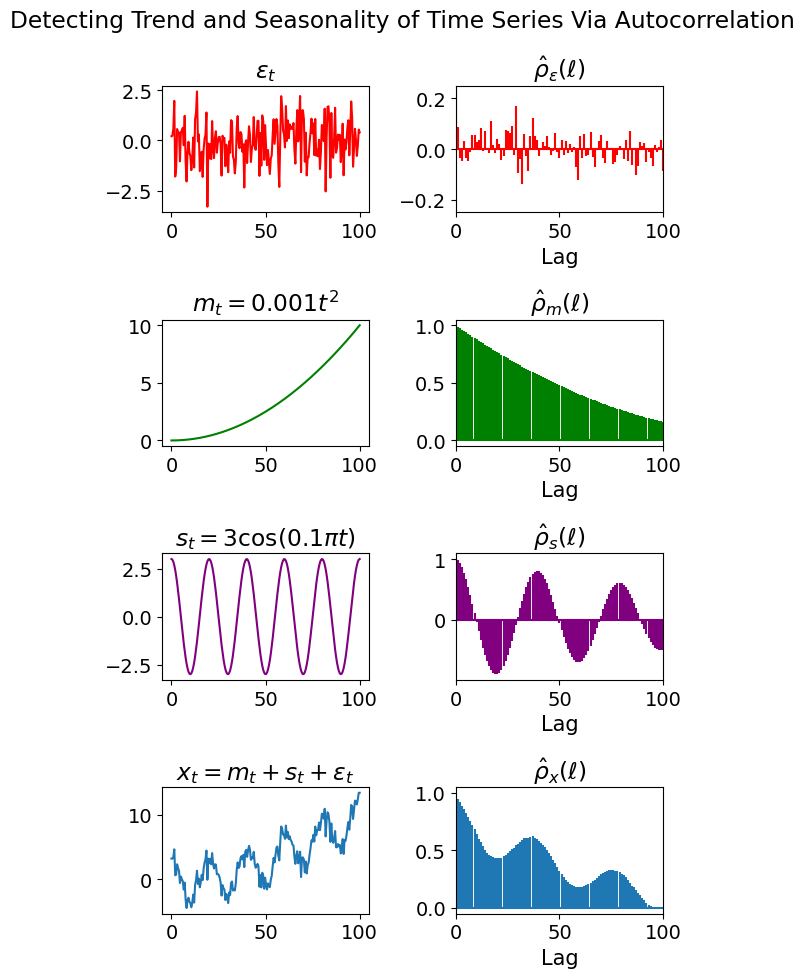

In [334]:
x = np.linspace(0,100,200)
noise = np.random.standard_normal(200)
m_t = 0.001*x**2
s_t = 3*np.cos(1/10*np.pi*x)
x_t = noise + m_t + s_t
fig, axs = plt.subplots(4,2, figsize=(6,10))
fig.suptitle('Detecting Trend and Seasonality of Time Series Via Autocorrelation')

axs[0,0].plot(x, noise, color='red')
axs[0,0].set_title(r'$\varepsilon_t$')
axs[0,1].acorr(noise, maxlags=100, color='red')
axs[0,1].set_xlim(0,100)
axs[0,1].set_ylim(-0.25,0.25)
axs[0,1].set_title(r'$\hat{\rho}_\epsilon(\ell)$')
axs[0,1].set_xlabel('Lag')

axs[1,0].plot(x, m_t, color='green')
axs[1,0].set_title(r'$m_t=0.001t^2$')
axs[1,1].acorr(m_t, maxlags=100, color='green')
axs[1,1].set_xlim(0,100)
axs[1,1].set_title(r'$\hat{\rho}_m(\ell)$')
axs[1,1].set_xlabel('Lag')

axs[2,0].plot(x, s_t, color='purple')
axs[2,0].set_title(r'$s_t=3 \cos(0.1\pi t)$')
axs[2,1].acorr(s_t, maxlags=100, color='purple')
axs[2,1].set_xlim(0,100)
axs[2,1].set_title(r'$\hat{\rho}_s(\ell)$')
axs[2,1].set_xlabel('Lag')

axs[3,0].plot(x, x_t)
axs[3,0].set_title(r'$x_t=m_t+s_t+\epsilon_t$')
axs[3,1].acorr(x_t, maxlags=100)
axs[3,1].set_xlim(0,100)
axs[3,1].set_xlabel('Lag')
axs[3,1].set_title(r'$\hat{\rho}_x(\ell)$')


plt.tight_layout()


## Property 7 (Leverage Effect)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


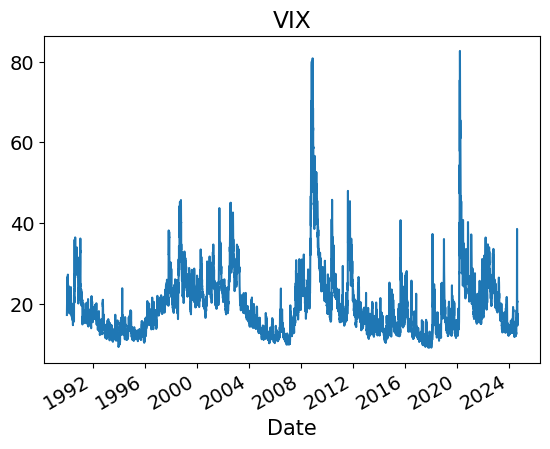

In [365]:
vix = {}
periods = ['5min', '30min']
intervals = ['5m', '30m']
for period, interval in zip(periods,intervals):
    vix[period] = yf.download('^VIX', period='max', interval=interval)['Adj Close']
    vix[period].name = 'VIX'

vix_daily = yf.download('^VIX', period='max', interval='1d')['Adj Close']
vix['daily'] = vix_daily
vix_daily.name = 'VIX'
vix['daily'].plot(title='VIX');

In [336]:
vix_MA = vix['daily'].groupby(pd.Grouper(freq='MS')).mean()

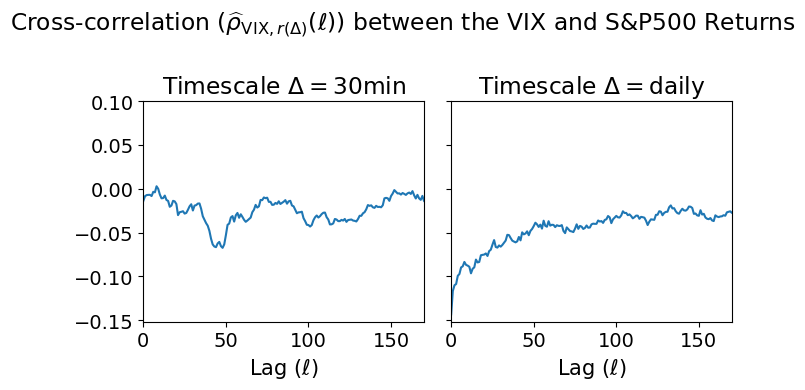

In [337]:
fig, axs = plt.subplots(1,2,figsize=(7,4), sharey=True, tight_layout=True)
periods = ['30min', 'daily']
fig.suptitle(r'Cross-correlation $(\widehat{\rho}_{\mathrm{VIX}, r(\Delta)}(\ell))$ between the VIX and S&P500 Returns')
for i, ax in enumerate(axs):
    period = periods[i]
    leverage_effect = cross_corr(vix[period], returns[period]['S&P500'], 1000)
    ax.plot(leverage_effect)
    ax.set_yticks(np.arange(-0.15,0.15,0.05))
    ax.set_xlim(0,170)
    ax.set_title(rf'Timescale $\Delta=${period}')
    # if i==0:
    #     ax.set_ylabel(r'$\rho_{\widebar{\mathrm{VIX}}, r(\Delta)}(\ell)$')
    ax.set_xlabel(r'Lag $(\ell)$')

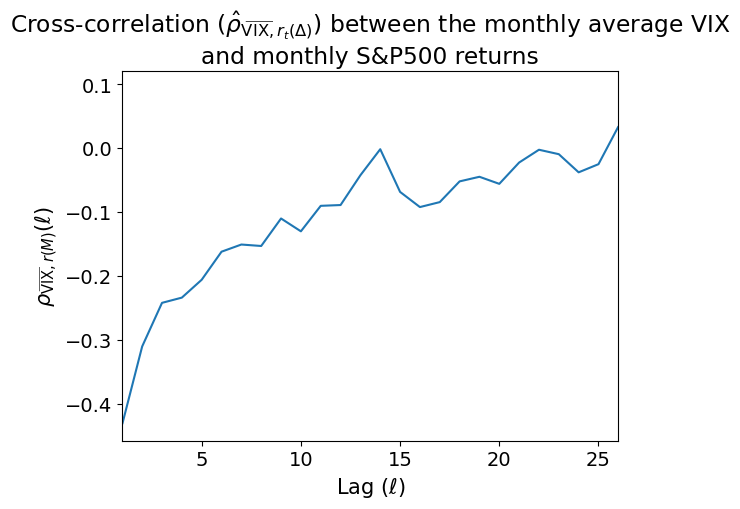

In [338]:
leverage_effect = cross_corr(vix_MA, returns['monthly']['S&P500'], 100)
plt.figure()
plt.plot(leverage_effect)
xlim = np.argmax(leverage_effect[1:]>=0)+1
plt.gca().set_xlim(1,xlim);
plt.gca().set_xlabel(r'Lag $(\ell)$')
plt.gca().set_ylabel(r'$\rho_{\widebar{\mathrm{VIX}}, r(M)}(\ell)$')
plt.gca().set_title('Cross-correlation $(\hat{\\rho}_{\widebar{\mathrm{VIX}},r_t(\Delta)})$ between the monthly average VIX\nand monthly S&P500 returns');

## GARCH models (volatility clustering and heavy tails)

 The package `yfinance` only allows us to obtain intraday prices at timescales $\Delta < $ 1 hour in the previous 60 days. For hourly observation windows however, we can go back much further (730 days). That is why this is the intraday timescale we will use to compute daily realized volatility."

[*********************100%%**********************]  1 of 1 completed


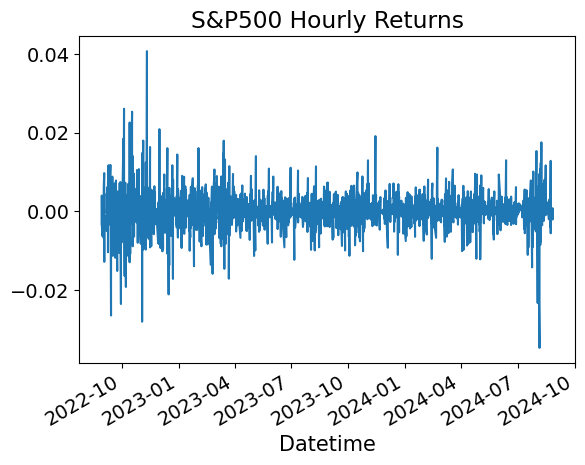

In [339]:
SPX_hourly_prices = yf.download('^SPX', period = 'max', interval = '1h' )
SPX_hourly_prices = SPX_hourly_prices['Adj Close']
SPX_hourly_prices.index = SPX_hourly_prices.index.tz_localize(None)
SPX_hourly_returns = np.log(SPX_hourly_prices / SPX_hourly_prices.shift(1)).dropna()
SPX_hourly_returns.plot(title='S&P500 Hourly Returns');

In [340]:
def realized_variance(group):
    if group.size == 0:
        return None
    squares = group**2
    return squares.sum()

In [341]:
SPX_hourly_GARCH = SPX_hourly_returns * 100

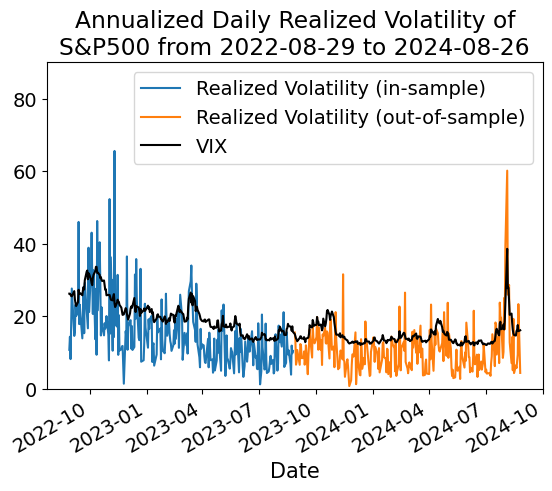

In [342]:
RV = SPX_hourly_GARCH.groupby(pd.Grouper(freq='d')).apply(realized_variance).dropna()
RV.name = 'Realized Variance'
RV.index.name = 'Date'
N = RV.size
N = RV.size
RV_train = RV.iloc[:N//2]
RV_test = RV.iloc[N//2:]

realized_vol = np.sqrt(252*RV)
realized_vol.name = 'Realized Volatility'
realized_vol_IS = realized_vol[:N//2]
realized_vol_IS.name = 'Realized Volatility (in-sample)'
realized_vol_OOS = realized_vol[N//2:]
realized_vol_OOS.name = 'Realized Volatility (out-of-sample)'
realized_vol_IS.plot()
realized_vol_OOS.plot()
vix['daily'][RV.index[0]:].plot(color='black')
plt.legend(loc='upper right')
plt.gca().set_ylim(0,90)
plt.title(f'Annualized Daily Realized Volatility of\nS&P500 from {RV.index[0].date()} to {RV.index[-1].date()}');

In [343]:
SPX_daily_GARCH = SPX_daily_returns[RV.index] * 100

In [344]:
def log_likelihood(x, var_0, ser):
    return np.sum(np.log(uncalibrated_GARCH(x, var_0, ser)) + RV / uncalibrated_GARCH(x, var_0, ser))

In [375]:
bounds = [(0.001, 1), (0.001,1), (0.001,1)]
x0 = [0.1,0.15,1]
GARCH_params = minimize(log_likelihood, args = (RV_train.iloc[0], SPX_daily_GARCH[RV_train.index]),  x0=x0, bounds=bounds)
GARCH_params = GARCH_params.x
[alpha_0, alpha_1, beta] = np.round(GARCH_params,4)
print(f'Calibrated parameters: alpha_0 = {alpha_0}, alpha_1 = {alpha_1}, beta = {beta}')

Calibrated parameters: alpha_0 = 0.0294, alpha_1 = 0.1609, beta = 0.8188


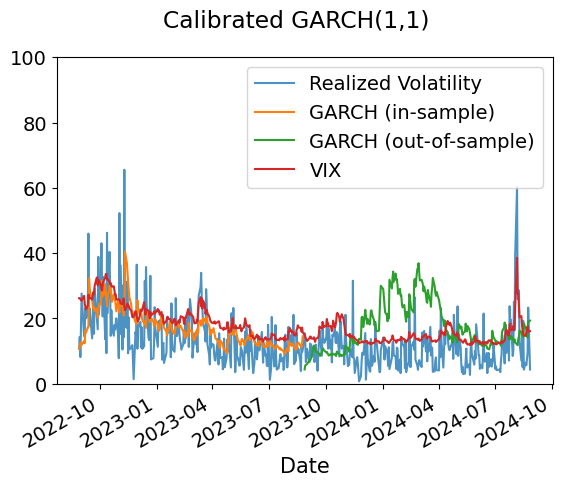

In [381]:
GARCH_IS = np.sqrt(252*uncalibrated_GARCH(GARCH_params, RV.iloc[0], SPX_daily_GARCH[RV_train.index]))
GARCH_OOS = np.sqrt(252*GARCH(GARCH_params, RV.iloc[-1], RV_test.index))
realized_vol.plot(alpha=0.8)
GARCH_IS.plot()
GARCH_OOS.plot()
vix['daily'][RV.index].plot()
plt.suptitle('Calibrated GARCH(1,1)')
plt.legend(loc='upper right')
plt.gca().set_ylim(0,100);

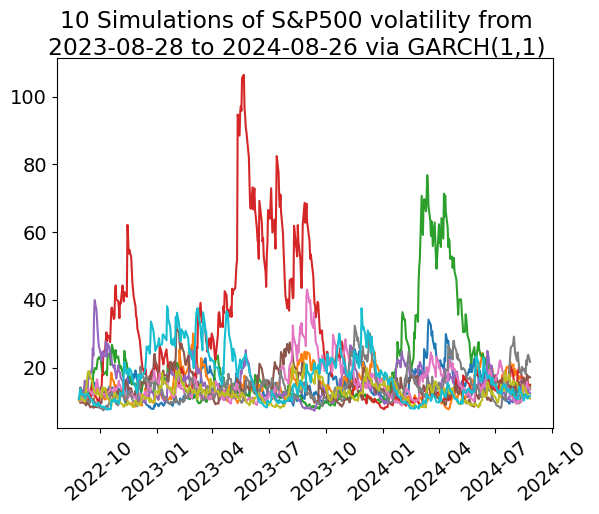

In [405]:
plt.figure()
plt.suptitle(f'10 Simulations of S&P500 volatility from\n{RV_test.index[0].date()} to {RV_test.index[-1].date()} via GARCH(1,1)')
for i in range(10):
    plt.plot(np.sqrt(252*GARCH(GARCH_params, RV.iloc[0], SPX_daily_GARCH.index)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt='%Y-%m'))
plt.xticks(rotation=40);

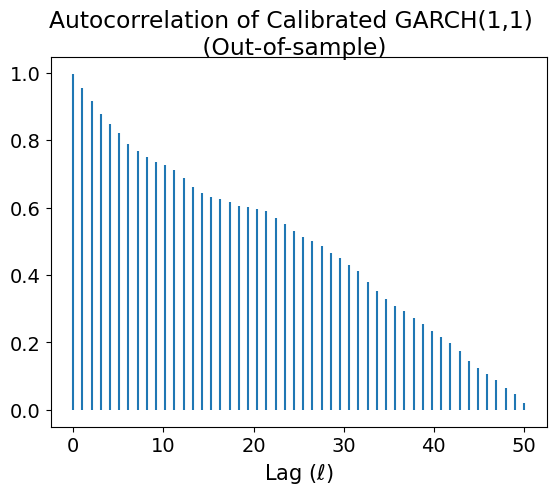

In [390]:
plt.figure()
plt.suptitle('Autocorrelation of Calibrated GARCH(1,1)\n (Out-of-sample)')
y=cross_corr(GARCH_OOS, GARCH_OOS)
maxlags = np.argmax(y<0.01)
y=y[:maxlags]
x=np.linspace(0,len(y),len(y))
plt.gca().vlines(x=x,ymin=0, ymax=y)
plt.gca().set_xlabel(r'Lag $(\ell)$');